# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

from nnn import train_nn as tnn
from pprint import pprint

In [2]:
mydata = tnn.MyData()
mydata.load_everything()

In [3]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')
annotation = pd.read_table('./data/annotation/NNNlib2b_annotation_2024.tsv', index_col=0)

ecl_oligo_df = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos.csv', index_col=0)

# Fig. 4a NN & NNN for WC and MM

In [5]:
wcmm_df = mydata.arr.query('Series == "WatsonCrick" | Series == "MisMatches"')
wcmm_df['n_mm'] = wcmm_df.TargetStruct.apply(lambda x: int((x.count('.')-4) / 2))
wcmm_df = wcmm_df.query('n_mm <= 1')

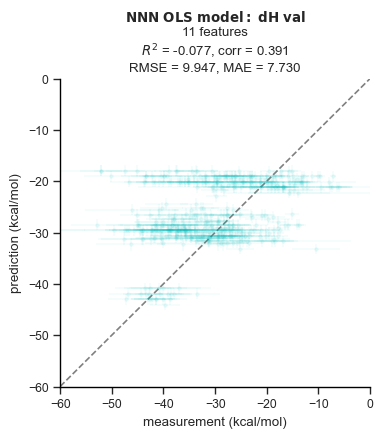

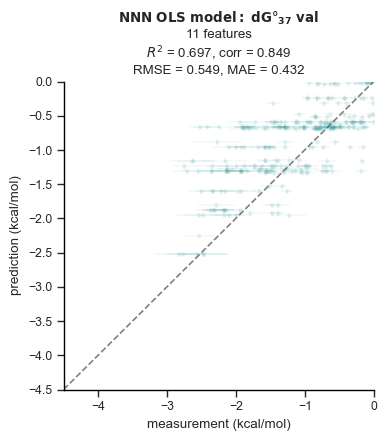

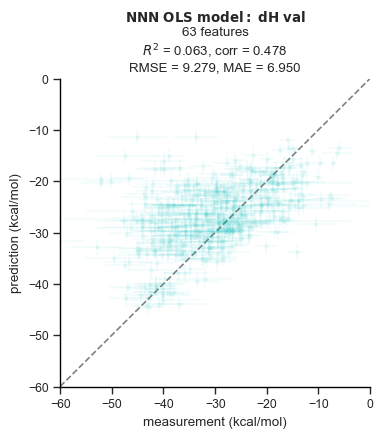

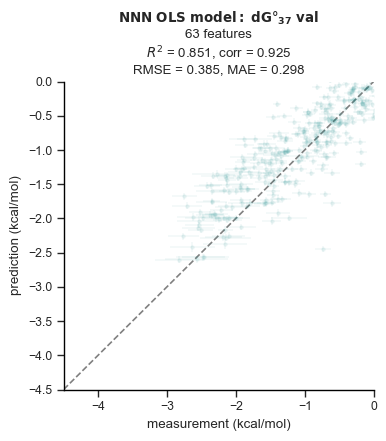

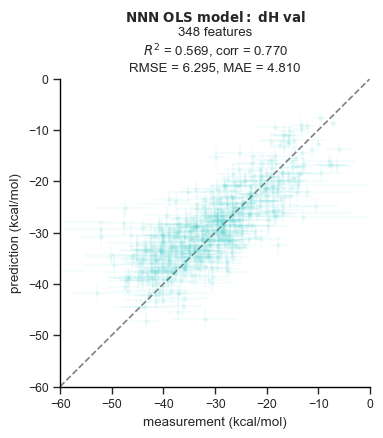

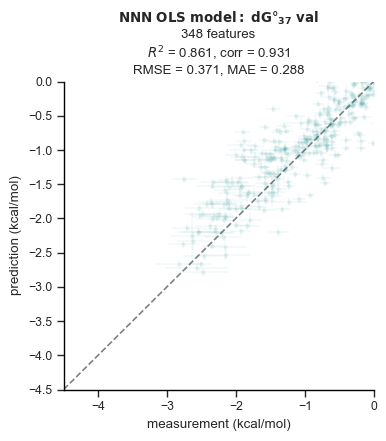

In [6]:
stack_size_list = [1, 2, 3]
lr_dict_list = []

for stack_size in stack_size_list:
    lr_dict = dict()
    feats = mf.get_feature_count_matrix(wcmm_df, 'get_mismatch_stack_feature_list', stack_size=stack_size, fit_intercept=True, symmetry=True)
    
    for p,p_full in dict(dH='dH', dG='dG_37').items():
        lr_dict[p] = mf.fit_param(wcmm_df, mydata.data_split_dict, p_full, feats)
    
    lr_dict_list.append(lr_dict)

In [7]:
val_df = mydata.get_df_by_split(wcmm_df, mydata.data_split_dict, data_split='test')

In [8]:
def test_param(param, plot=True):
    if plot:
        fig, ax = plt.subplots(2, 3, figsize=(6,4), sharex=True, sharey=True)
    val_res_dict = dict()
    for i,n in enumerate([0, 1]):
        for j,stack_size in enumerate(stack_size_list):
            print('n_mm = %d, stack_size = %d' % (n, stack_size))
            print(len(val_df.query('n_mm == %d' % n)))
            val_res_df = modeling.make_model_validation_df(
                val_df.query('n_mm == %d' % n),
                model='linear_regression',
                model_kwargs=dict(lr_dict=lr_dict_list[j], 
                                  feature_method='get_mismatch_stack_feature_list',
                                  stack_size=stack_size,
                                  fit_intercept=True,
                                  symmetry=True),
            )
            val_res_dict['n_mm_%d_stack_size_%d' % (n, stack_size)] = modeling.get_metric_dict(val_res_df, param)
            if plot:
                modeling.plot_validation_result(val_res_df, param, ax=ax[i,j])
                util.beutify(ax[i,j])

    if plot:
        plt.show()
        util.save_fig('./fig/Fig4/stack_size_wc_mm/scatter_%s.pdf' % param)
    val_result_df = pd.DataFrame(val_res_dict).T
    val_result_df['n_mm'] = [0,0,0,1,1,1]
    val_result_df['stack_size'] = [1,2,3,1,2,3]
    return val_result_df

def normalize_metric_2_stack_1(val_result_df):
    norm_vec = val_result_df[metric].values
    norm_vec[:3] = norm_vec[:3] / norm_vec[0]
    norm_vec[3:] = norm_vec[3:] / norm_vec[3]
    norm_vec *= 100
    val_result_df[metric+'_norm'] = norm_vec
    
    return val_result_df

n_mm = 0, stack_size = 1
101
n_mm = 0, stack_size = 2
101
n_mm = 0, stack_size = 3
101
n_mm = 1, stack_size = 1
358
n_mm = 1, stack_size = 2
358
n_mm = 1, stack_size = 3
358
n_mm = 0, stack_size = 1
101
n_mm = 0, stack_size = 2
101
n_mm = 0, stack_size = 3
101
n_mm = 1, stack_size = 1
358
n_mm = 1, stack_size = 2
358
n_mm = 1, stack_size = 3
358


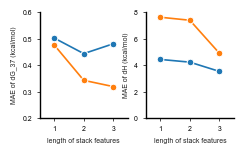

In [9]:
def plot_stack_len_err(param, metric, ax, norm_suffix = ''):
    val_result_df = test_param(param, plot=False)
    sns.lineplot(data=val_result_df, x='stack_size', y=metric+norm_suffix, hue='n_mm', marker='o', ax=ax)
    if param == 'dG_37':
        ax.set_ylim([.2,.6])
    elif param == 'dH':
        ax.set_ylim([0,8])
    ax.set_xlim([.5,3.5])
    ax.set_xlabel('length of stack features')
    ax.set_ylabel('MAE of %s (kcal/mol)'%param)
    ax.get_legend().remove()
    util.beutify(ax, x_locator=1, shrink=True, do_not_resize=True)
    
fig, a = plt.subplots(1,2,figsize=(4.25*1.5*cm, 3.5*cm))
plot_stack_len_err(param='dG_37', metric='adjusted_mae', ax=a[0])
plot_stack_len_err(param='dH', metric='adjusted_mae', ax=a[1])
util.save_fig('./fig/Fig4/stack_size_wc_mm/dH_dG_mae_test.pdf')

# Parameter visualization

## Fig. 4b Model for stack parameter plotting

(27732, 1338)
CPU times: user 3min 18s, sys: 2min 17s, total: 5min 36s
Wall time: 1min 27s


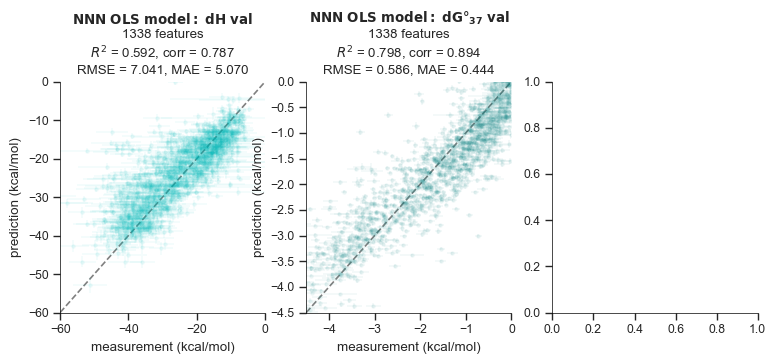

In [10]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=False, ignore_base_stack=False)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 3, figsize=(9,3))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

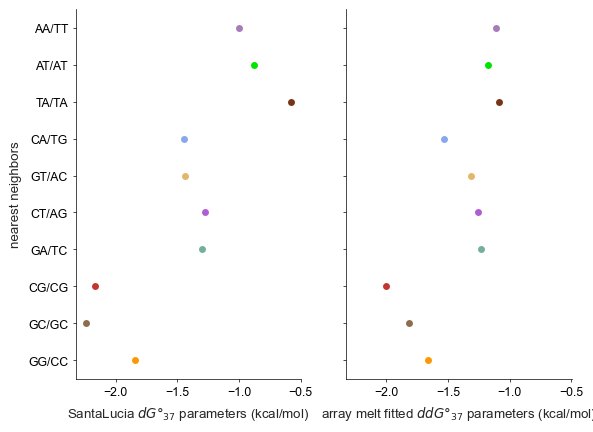

In [11]:
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

santa_lucia['feats'] = santa_lucia['motif'].apply(lambda x: x.replace('_','+') + '_((+))')
coef_df = lr_dict['dG'].coef_df.join(lr_dict['dH'].coef_df.rename(columns={'dG_37':'dH'}))
fit_vs_sl = santa_lucia.set_index('feats').join(
    coef_df, 
    lsuffix='_SantaLucia', rsuffix='_NNN')
fit_vs_sl['nearest neighbors'] = fit_vs_sl['motif'].apply(lambda x: x.replace('_','/'))
fit_vs_sl['dG_37_NNN'] +=  - np.mean(fit_vs_sl['dG_37_NNN']) + np.mean(fit_vs_sl['dG_37_SantaLucia'])
fit_vs_sl['dH_NNN'] +=  - np.mean(fit_vs_sl['dH_NNN']) + np.mean(fit_vs_sl['dH_SantaLucia'])

"""dG"""
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_SantaLucia', ax=ax[0], palette='cet_glasbey_dark')
ax[0].set_xlabel(r'SantaLucia $dG°_{37}$ parameters (kcal/mol)')
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_NNN', ax=ax[1], palette='cet_glasbey_dark')
ax[1].set_xlabel(r'array melt fitted $ddG°_{37}$ parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax)
util.save_fig('./fig/Fig4/NN_param_ArrayMelt_vs_SantaLucia_dG_37.pdf')

## Visualize parameters from files

In [12]:
param_set_template_file = './models/dna04.json'
param_json_file = './models/ancient-cloud-136.json'
param_mupack_file = './models/dna-nnn-mm-adj.json'
# param_json_file = './models/swift-lake-118.json'
# param_json_file = './models/efficient-yogurt-135.json'

In [13]:
p_old_dict = fileio.read_json(param_set_template_file)
p_new_dict = fileio.read_json(param_json_file)
p_mupack_dict = fileio.read_json(param_mupack_file)

Seems that hairpin mismatches are consistently higher than interior.

### WC (sanity check)

Different model from above. The WC parameters are fixed here and should be identical.

In [14]:
key = 'stack'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

def is_wc_stack(stack):
    return stack[0] == util.rcompliment(stack[-1]) and stack[1] == util.rcompliment(stack[-2])

df = df.loc[df.RefSeq.apply(is_wc_stack)]

# df.new -= np.mean(df.new) - np.mean(df.old)

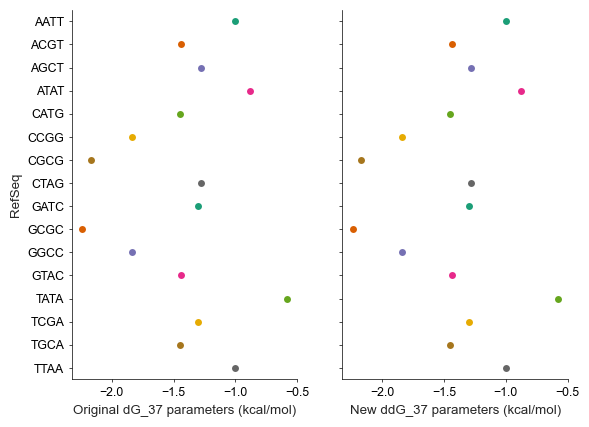

In [15]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
palette = 'Dark2'
sns.stripplot(data=df, orient='h', y='RefSeq', x='old', ax=ax[0], palette=palette)
ax[0].set_xlabel('Original dG_37 parameters (kcal/mol)')
sns.stripplot(data=df, orient='h', y='RefSeq', x='new', ax=ax[1], palette=palette)
ax[1].set_xlabel('New ddG_37 parameters (kcal/mol)')
ax[1].set_ylabel('')
util.beutify_all_ax(ax, x_locator=.5)

util.save_fig('./fig/Fig4/WC/WC_original_vs_new_dG_37.pdf')

### Fig. 4c Interior mismatch

In [16]:
key = 'interior_1_1'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

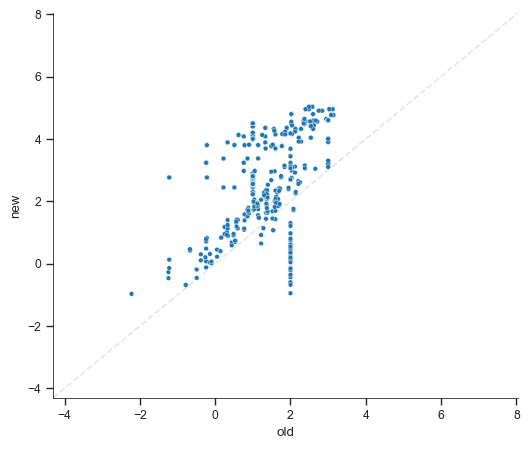

In [17]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [18]:
def get_mm(seq):
    if seq[4] != util.rcompliment(seq[1]):
        return f'{seq[1]}·{seq[4]}'
    else:
        return np.nan

def get_context(seq):
    if seq[-1] == util.rcompliment(seq[0]) and seq[3] == util.rcompliment(seq[2]):
        return f'{seq[0]}{seq[-1]}x{seq[2]}{seq[3]}'
    else:
        return np.nan

df['mm'] = df.RefSeq.apply(get_mm)
df['context'] = df.RefSeq.apply(get_context)

df = df.dropna()

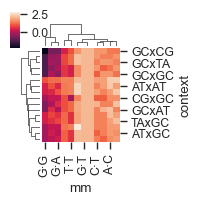

In [19]:
pivot_new = df.pivot_table(index='context', columns='mm', values='new')
pivot_old = df.pivot_table(index='context', columns='mm', values='old')
pivot_diff = pivot_new - pivot_old
clustergrid = sns.clustermap(pivot_old, figsize=(2,2))

reordered_index, reordered_columns = util.get_reordered_ind(clustergrid, pivot_new)

Text(0.5, 1.0, 'old NUPACK $dG°_{37}$ parameters (kcal/mol)')

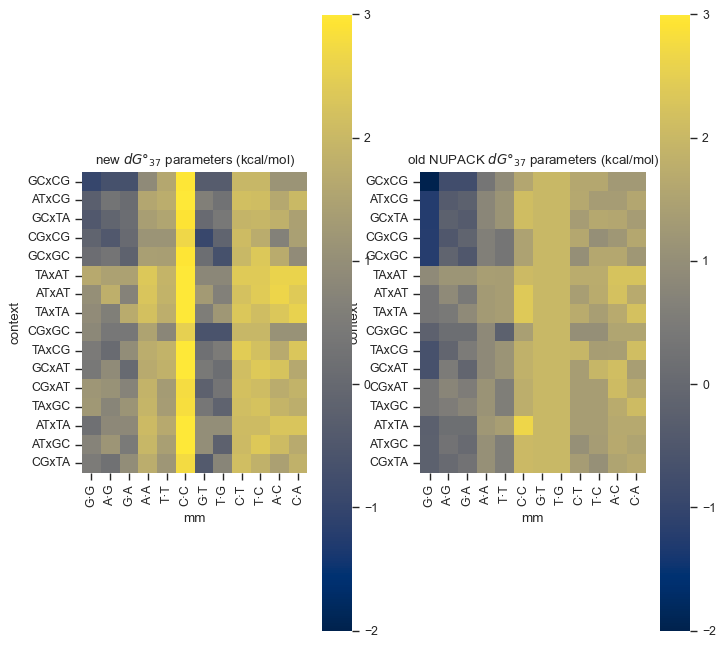

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharex=False)
args = dict(vmin=-2, vmax=3, cmap='cividis', square=True)

sns.heatmap(pivot_new.loc[reordered_index, reordered_columns], ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_old.loc[reordered_index, reordered_columns], ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')

# util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_single_mismatch.pdf')

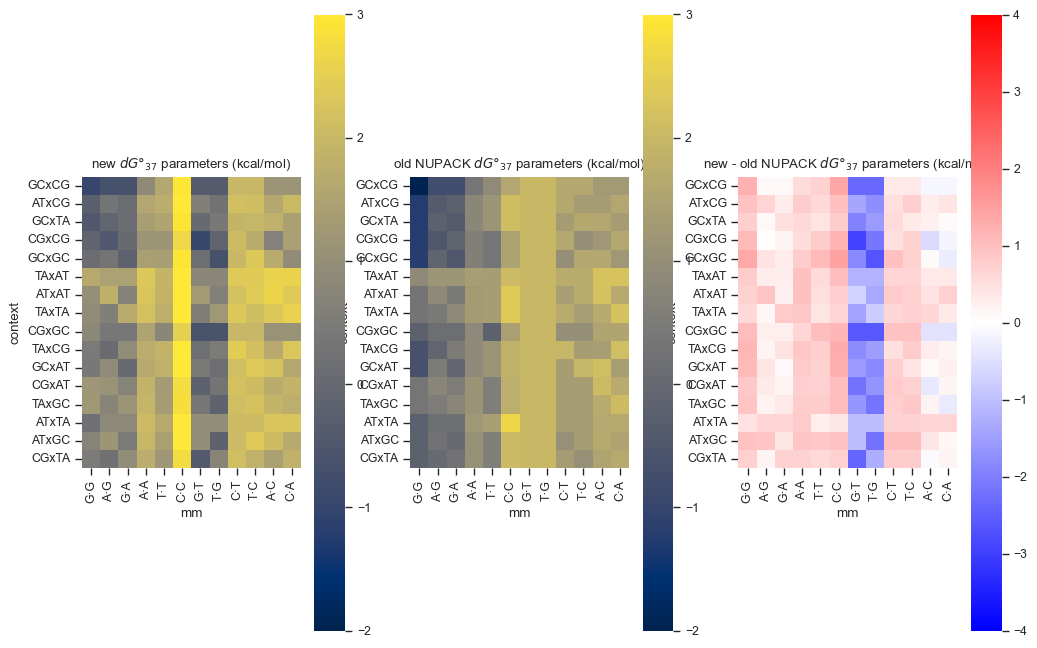

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,8), sharex=False)
# args = dict(vmin=-2, vmax=3, cmap='cividis', square=True)
args = dict(vmin=-2, vmax=3, cmap='cividis', square=True)

sns.heatmap(pivot_new.loc[reordered_index, reordered_columns], ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_old.loc[reordered_index, reordered_columns], ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_new.loc[reordered_index, reordered_columns] - pivot_old.loc[reordered_index, reordered_columns], 
            ax=ax[2], vmin=-4, vmax=4, cmap='bwr', square=True)
ax[2].set_title('new - old NUPACK $dG°_{37}$ parameters (kcal/mol)')

util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_single_mismatch_with_diff.pdf')

### Hairpin mismatch

In [22]:
key = 'hairpin_mismatch'
df = pd.DataFrame(data=dict(old=p_old_dict['dG'][key], new=p_new_dict['dG'][key]))
df = df.rename_axis('RefSeq').reset_index().query('old != 0')

In [23]:
df

,RefSeq,old,new
0,AATA,-0.6,-0.279031
1,AATC,-0.5,-0.402789
2,AATG,-0.6,-1.181472
3,AATT,-0.8,-0.830867
4,ACGA,-1.0,-0.121499
...,...,...,...
91,TTAT,-0.4,-0.530910
92,TTGA,-0.6,-0.600000
93,TTGC,-0.2,-0.200000
94,TTGG,-0.5,-0.500000


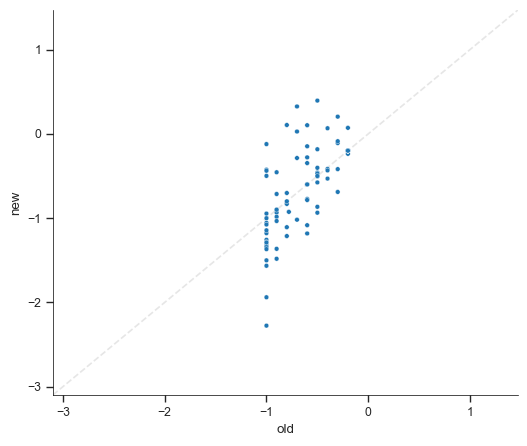

In [24]:
plotting.plot_colored_scatter_comparison(data=df, x='old', y='new', color_by_density=False)

In [25]:
def get_mm(seq):
    return f'{seq[0]}·{seq[3]}'

def get_closing(seq):
    return f'{seq[2]}-{seq[1]}'

df['mm'] = df.RefSeq.apply(get_mm)
df['closing'] = df.RefSeq.apply(get_closing)

df = df.dropna()

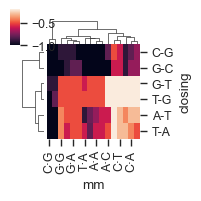

In [26]:
pivot_new = df.pivot_table(index='closing', columns='mm', values='new')
pivot_old = df.pivot_table(index='closing', columns='mm', values='old')
pivot_diff = pivot_new - pivot_old
clustergrid = sns.clustermap(pivot_old, figsize=(2,2))

reordered_index, reordered_columns = util.get_reordered_ind(clustergrid, pivot_new)

Text(0.5, 1.0, 'old NUPACK $dG°_{37}$ parameters (kcal/mol)')

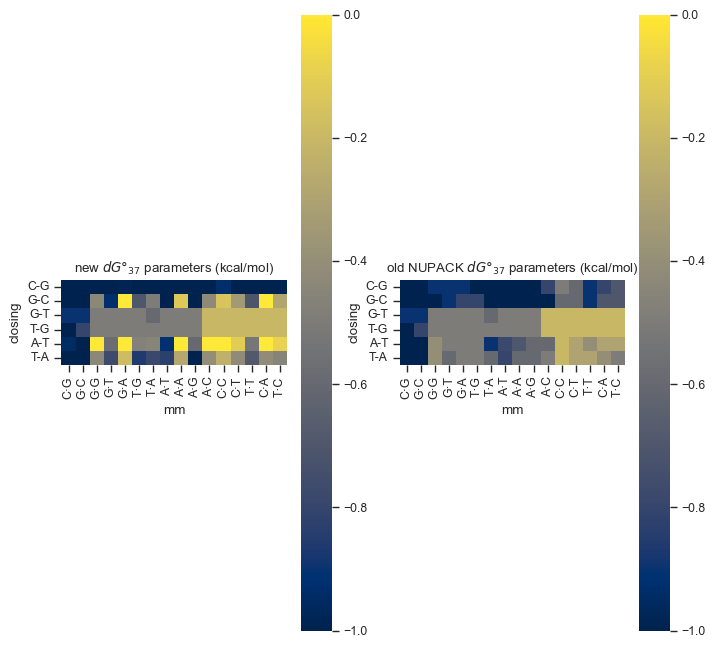

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharex=False)
args = dict(vmin=-1, vmax=0, cmap='cividis', square=True)

sns.heatmap(pivot_new.loc[reordered_index, reordered_columns], ax=ax[0], **args)
ax[0].set_title('new $dG°_{37}$ parameters (kcal/mol)')
sns.heatmap(pivot_old.loc[reordered_index, reordered_columns], ax=ax[1], **args)
ax[1].set_title('old NUPACK $dG°_{37}$ parameters (kcal/mol)')

# util.save_fig('./fig/Fig4/ParamHeatmap/new_vs_old_dG_single_mismatch.pdf')

# Model performance

## Fig. 4d,4g,S4e test result scatter plot

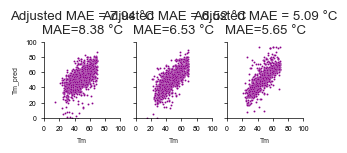

In [28]:
# run_name = 'dna04'
# run_name = 'hyb-adj-ext-test'
run_names = ['dna04', 'hyb-adj-ext-test', 'vivid-spaceship-120']
p = 'Tm'

fig, ax = plt.subplots(1, 3, figsize=(2*4.25*cm, 3.5*cm), sharey=True)
for i,run_name in enumerate(run_names):
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    metric_dict = modeling.get_metric_dict(
        val_result_df.query('DatasetName == "arr"'),
        p
    )
    sns.scatterplot(
                data=val_result_df.query('DatasetName == "arr"'),
                x=p,
                y=f'{p}_pred',
                color='darkmagenta',
                linewidth=0.1,
                s=2,
                rasterized=False,
                ax=ax[i]
            )
    ax[i].axis('square')
    spacing = 20
    ax[i].set_title('Adjusted MAE = %.2f °C\nMAE=%.2f °C' % (metric_dict['adjusted_mae'], metric_dict['mae']))
    util.beutify(ax[i], x_locator=spacing, y_locator=spacing, 
                 force_same_xy=True, add_margin=.1, shrink=True, do_not_resize=True)
    ax[i].set_xlim([0,100])
    ax[i].set_ylim([0,100])
    
    
util.save_fig(f'./fig/Fig4/Validation/{p}_arr_all_scatter.pdf')

In [29]:
def plot_val_result_scatter(run_name, p='Tm', 
                            kalvin_Tm=False, center_Tm=True):
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

    val_result_df = val_result_df.join(mydata.annotation[['Series']])
    
    df_q = val_result_df.query('DatasetName == "arr"')

    df_q = df_q.query(f'{p}_pred < 300 and {p}_pred > -300')

    # arr by Series
    fig, ax = plt.subplots(1, 5, figsize=(9.2*cm,3*cm), sharey=False, sharex=False)
    for i,s in enumerate(['WatsonCrick', 'MisMatches', 'Bulges', 'TETRAloop', 'TRIloop']):
        matplotlib.rc('axes',edgecolor='k', linewidth=.5)
        sns.scatterplot(
            data=df_q.query(f'Series == "{s}"'),
            x=p,
            y=f'{p}_pred',
            color='darkmagenta',
            linewidth=0.1,
            s=2,
            rasterized=False,
            ax=ax[i]
        )
        ax[i].axis('square')
        if p == 'Tm':
            tick_spacing = 20
        else:
            tick_spacing = 2
            
        util.beutify(ax[i], x_locator=tick_spacing, y_locator=tick_spacing, 
                     force_same_xy=True, add_margin=.2, shrink=True, do_not_resize=True)
        # ax[i].set_title(s)
        metric = modeling.get_metric_dict(df_q.query(f'Series == "{s}"'), p)
        # ax[i].set_title('%s\nMAE = %.2f\ncorr = %.2f' % (s, metric['adjusted_mae'], metric['corr']))
        ax[i].set_title('MAE = %.2f\nR = %.2f\nR2= %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
        ax[i].set_ylabel(None)

    fig.tight_layout(pad=.1, w_pad=0)
    util.save_fig('./fig/Fig4/scatterplot/%s/array_test.pdf' % run_name)
    
    # all of lit_uv and ov
    fig, ax = plt.subplots(1, 2, figsize=(4,1.8), sharey=False, sharex=False)
    for i,dn in enumerate(['lit_uv', 'ov']):
        df_q = val_result_df.query(f'DatasetName == "{dn}"')
            
        if kalvin_Tm:
            df_q.Tm_pred -= 273.15

        if center_Tm:
            Tm_med = np.nanmedian(df_q.Tm)
            df_q.Tm_pred += Tm_med - np.nanmedian(df_q.Tm_pred)
        
        sns.scatterplot(
            data=df_q,
            x='Tm',
            y='Tm_pred',
            color='indigo',
            linewidth=0.1,
            ax=ax[i]
        )
        ax[i].axis('square')
        util.beutify(ax[i], x_locator=20, y_locator=20, 
                     force_same_xy=True, add_margin=.1)
        # metric = modeling.get_metric_dict(df_q, p)
        # ax[i].set_title(dn)
        # ax[i].set_title('MAE = %.2f\nR = %.2f\nR2= %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
        ax[i].set_ylabel(None)
        ax[i].set_ylabel(None)
    fig.tight_layout()
    util.save_fig('./fig/Fig4/scatterplot/%s/lit_uv_ov_test.pdf' % run_name)

    # ov by n_mm
    fig, ax = plt.subplots(1, 4, figsize=(8*cm,2*cm), sharey=True, sharex=True)
    df_q = val_result_df.query('DatasetName == "ov"')
    df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
    if kalvin_Tm:
        df_q.Tm_pred -= 273.15
        
    if center_Tm:
        Tm_med = np.nanmean(df_q.Tm)
        df_q.Tm_pred += Tm_med - np.nanmean(df_q.Tm_pred)
        
    ov_nmm_arr = np.zeros(4)
    for n in range(4):
        sns.scatterplot(
            data=df_q.query('n_mm == %d' % n),
            x='Tm',
            y='Tm_pred',
            color='darkslateblue',
            linewidth=0.1,
            s=2,
            ax=ax[n]
        )
        lim = (35,80)
        metric = modeling.get_metric_dict(df_q.query('n_mm == %d' % n), 'Tm')
        ax[n].set_xlim(lim)
        ax[n].set_ylim(lim)
        util.beutify(ax[n], x_locator=10, y_locator=10, shrink=True, do_not_resize=True)
        # ax[n].set_title('%d mismatch(s)' % n)
        ax[n].set_title('MAE = %.2f\nR = %.2f, R2 = %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
        ov_nmm_arr[n] = metric['r2']
        
    util.save_fig('./fig/Fig4/scatterplot/%s/ov_test.pdf' % run_name)
    return ov_nmm_arr
    
    
def plot_arr_val_result_scatter(run_name, p='Tm', ensemble=False,
                            kalvin_Tm=False, center_Tm=True):
    if ensemble:
        fn = os.path.join('./models/', run_name+'_val_result_df_ensemble.csv')
    else:
        fn = os.path.join('./models/', run_name+'_val_result_df.csv')
    val_result_df = pd.read_csv(fn, index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

    val_result_df = val_result_df.join(mydata.annotation[['Series']])
    
    df_q = val_result_df.query('DatasetName == "arr"')

    df_q = df_q.query(f'{p}_pred < 300 and {p}_pred > -300')

    # arr
    fig, ax = plt.subplots(1, 1, figsize=(3*cm,3.5*cm), sharey=False, sharex=False)
 
    
    sns.scatterplot(
        data=df_q,
        x=p,
        y=f'{p}_pred',
        color='darkmagenta',
        linewidth=0.1,
        s=2,
        ax=ax
    )
    # ax.axis('square')
    if p == 'Tm':
        tick_spacing = 20
    else:
        tick_spacing = 2

    util.beutify(ax, x_locator=tick_spacing, y_locator=tick_spacing, 
                 force_same_xy=True, add_margin=.2, shrink=True, do_not_resize=True)
    metric = modeling.get_metric_dict(df_q, p)
    ax.set_title('MAE = %.2f kcal/mol\nR = %.2f  R2 = %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
    ax.set_ylabel(None)

    fig.tight_layout()
    util.save_fig('./fig/Fig4/scatterplot/%s/array_test_all.pdf' % run_name)

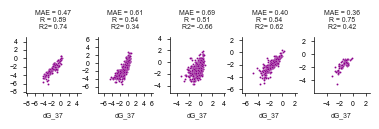

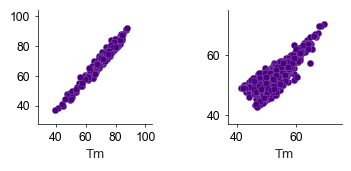

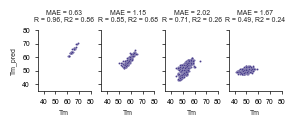

In [30]:
# run_names = ['dna04', # original nupack model
#     'swift-lake-118', # 178 NUPACK-compatible model
#     'hyb-adj-val', # updated NUPACK-compatible model
#     'vivid-spaceship-120',] # 1338 richer parameterization model
run_names = [
    # 'swift-lake-118', # 178 NUPACK-compatible model
    'hyb-adj-ext-test',]
ov_nmm_r2_arr = np.zeros((len(run_names),4))
for i,run_name in enumerate(run_names):
    ov_nmm_r2_arr[i,:] = plot_val_result_scatter(run_name, p='dG_37', kalvin_Tm=True)
    util.save_multi_image('./fig/Fig4/Validation/%s_val_result.pdf'%run_name)

In [31]:
for run_name in run_names:
    print('===', run_name, '===')
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

    df_q = val_result_df.query('DatasetName == "ov"')
    df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
    df_q = df_q.query('n_mm == 2')

    pprint(modeling.get_metric_dict(df_q, 'Tm')['r2'])

=== hyb-adj-ext-test ===
0.2644025575184489


## Fig. 4e bar plot

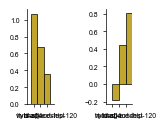

In [32]:
run_name_list = ['dna04', 'hyb-adj-ext-test', 'vivid-spaceship-120']

run_metric_dict = {k:None for k in run_name_list}

for run_name in run_name_list:
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    metric_dict = modeling.get_metric_dict(
        val_result_df.query('DatasetName == "arr"'),
        'dG_37'
    )
    run_metric_dict[run_name] = metric_dict

fig, ax = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm))
tmp_row = pd.DataFrame(data=run_metric_dict).loc['mae',:]
ax[0].bar(x=tmp_row.index.tolist(), height=tmp_row.values,
        width=1, color=np.array([193,167,47])/256, edgecolor='k', linewidth=.5)
ax[0].set_xlim([-1,3])

tmp_row = pd.DataFrame(data=run_metric_dict).loc['r2',:]
ax[1].bar(x=tmp_row.index.tolist(), height=tmp_row.values,
        width=1, align='edge',color=np.array([193,167,47])/256, edgecolor='k', linewidth=.5)
ax[1].set_xlim([-1,3])
util.beutify_all_ax(ax, shrink=True, do_not_resize=True)
plt.tight_layout()
util.save_fig('./fig/Fig4/arr_test_metric.pdf')

In [33]:
run_name = 'hyb-adj-ext-test'
# run_name = 'dna04'
val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
metric_dict = modeling.get_metric_dict(
    val_result_df.query('DatasetName == "arr"'),
    'dG_37'
)
print(json.dumps(metric_dict, indent=4))
# print('Adj MAE:\t%.2f\nMAE:\t\t%.2f\nR2:\t\t%.2f' % (metric_dict['adjusted_mae'], metric_dict['mae'], metric_dict['r2']))

{
    "bias": -0.41670602359597675,
    "corr": 0.8009525462376043,
    "rmse": 0.8888859774683753,
    "adjusted_rmse": 0.7851588188632526,
    "mae": 0.6738216068568971,
    "adjusted_mae": 0.5932768933621436,
    "r2": 0.43933037082530046
}


## Fig. 4f bar plot

In [34]:
run_name_list = ['dna04', 'hyb-adj-ext-test', 'vivid-spaceship-120']
all_metric_dict = dict()

for run_name in run_name_list:

    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    df_q = val_result_df.query('DatasetName == "ov"')
    df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
    run_metric_dict = {k:None for k in range(4)}

    for n_mm in range(4):

        metric_dict = modeling.get_metric_dict(
            df_q.query(f'n_mm == {n_mm}'),
            'Tm'
        )
        run_metric_dict[n_mm] = metric_dict

    all_metric_dict[run_name] = run_metric_dict


df = pd.DataFrame.from_dict(all_metric_dict, orient='index')
for i,row in df.iterrows():
    for j in range(4):
        df.loc[i,j] = df.loc[i,j]['r2']

In [35]:
for run_name in run_name_list:
    m = all_metric_dict[run_name][1]['adjusted_mae']
    print('%.2f'%m)

1.66
1.15
0.95


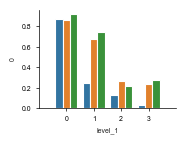

In [36]:
fig, ax = plt.subplots()
sns.barplot(data=df.stack().reset_index(), x='level_1', y=0, hue='level_0', 
            ax=ax)
ax.set_xlim([-1,4])
ax.get_legend().remove()
util.beutify(ax, shrink=True)

In [37]:
# run_name = 'hyb-adj-ext-test'
run_name = 'vivid-spaceship-120'
# run_name = 'dna04'
val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
df_q = val_result_df.query('DatasetName == "ov"')
df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int(x.count('.') / 2))
run_metric_dict = {k:None for k in range(4)}

for n_mm in range(4):

    metric_dict = modeling.get_metric_dict(
        df_q.query(f'n_mm == {n_mm}'),
        'Tm'
    )
    run_metric_dict[n_mm] = metric_dict

In [38]:
print('R2')
for n in run_metric_dict:
    print('Tm_ov_%dmm_r2 = %.2f' % (n, run_metric_dict[n]['r2']))

print('\nAdjusted MAE')
for n in run_metric_dict:
    print('Tm_ov_%dmm_adj_mae = %.2f' % (n, run_metric_dict[n]['adjusted_mae']))

print('\nMAE')
for n in run_metric_dict:
    print('Tm_ov_%dmm_mae = %.2f' % (n, run_metric_dict[n]['mae']))

R2
Tm_ov_0mm_r2 = 0.92
Tm_ov_1mm_r2 = 0.75
Tm_ov_2mm_r2 = 0.21
Tm_ov_3mm_r2 = 0.27

Adjusted MAE
Tm_ov_0mm_adj_mae = 0.47
Tm_ov_1mm_adj_mae = 0.95
Tm_ov_2mm_adj_mae = 2.09
Tm_ov_3mm_adj_mae = 1.60

MAE
Tm_ov_0mm_mae = 15.69
Tm_ov_1mm_mae = 14.16
Tm_ov_2mm_mae = 11.11
Tm_ov_3mm_mae = 7.52


In [39]:
df_q = val_result_df.query('DatasetName == "lit_uv"')
metric_dict = modeling.get_metric_dict(
    df_q,
    'Tm'
)
print('Literature UV===\nAdjusted MAE = %.2f\nMAE = %.2f\nR2=%.2f' % (metric_dict['adjusted_mae'], metric_dict['mae'], metric_dict['r2']))

Literature UV===
Adjusted MAE = 1.93
MAE = 11.99
R2=0.94


## Fig. 4h % training data

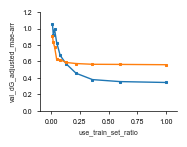

In [40]:
wandb_df = pd.read_csv('./data/wandb/wandb_export_2023-12-02T19_55_56.736-08_00.csv')

query = 'use_train_set_ratio <= 1'

fig, ax = plt.subplots(figsize=(4,3))
sns.lineplot(data=wandb_df.query(query), 
             x='use_train_set_ratio', y='val_dG_adjusted_mae-arr',
            ax=ax, hue='feature_method', marker='s', markersize=2, markeredgecolor=None,linewidth=1)
ax.set_ylim(bottom=0, top=1.2)
# ax.set_ylim(bottom=0)
ax.set_xlim([-.1,1.1])
plotting.beutify(ax, shrink=True)
ax.get_legend().remove()
util.save_fig('./fig/Fig4/mae.pdf')

## **Fig. S4b** two-state vs ensemble

./models/dna04_val_result_df.csv
./models/dna04_val_result_df_ensemble.csv
./models/hyb-adj-ext-test_val_result_df.csv
./models/hyb-adj-ext-test_val_result_df_ensemble.csv


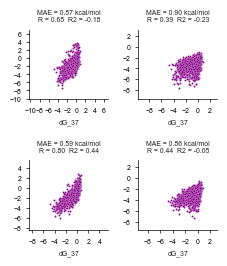

In [41]:
def plot_arr_val_result_scatter(run_name, p='Tm', ensemble=False,
                            kalvin_Tm=False, center_Tm=True, ax=None):
    if ensemble:
        fn = os.path.join('./models/', run_name+'_val_result_df_ensemble.csv')
    else:
        fn = os.path.join('./models/', run_name+'_val_result_df.csv')
    print(fn)
    val_result_df = pd.read_csv(fn, index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    val_result_df = val_result_df.join(mydata.annotation[['Series']])  
    df_q = val_result_df.query('DatasetName == "arr"')
    # df_q = df_q.query(f'{p}_pred < 300 and {p}_pred > -300')
   
    sns.scatterplot(
        data=df_q,
        x=p,
        y=f'{p}_pred',
        color='darkmagenta',
        linewidth=0.1,
        s=2,
        ax=ax
    )
    # ax.axis('square')
    if p == 'Tm':
        tick_spacing = 20
    else:
        tick_spacing = 2

    util.beutify(ax, x_locator=tick_spacing, y_locator=tick_spacing, 
                 force_same_xy=True, add_margin=.2, shrink=True, do_not_resize=True)
    metric = modeling.get_metric_dict(df_q, p)
    ax.set_title('MAE = %.2f kcal/mol\nR = %.2f  R2 = %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
    ax.set_ylabel(None)

    
run_names = ['dna04', # original nupack model dna04
    'hyb-adj-ext-test',] # NUPACK-compatible model dna24
fig, ax = plt.subplots(2, 2, figsize=(6*cm,7*cm), sharey=False, sharex=False)
 
for i,run_name in enumerate(run_names):
    for j in range(2):
        plot_arr_val_result_scatter(run_name, p='dG_37', kalvin_Tm=True, ensemble=j, ax=ax[i,j])
        
fig.tight_layout()
util.save_fig('./fig/Fig4/nupack_2state_ensemble_scatter.pdf')

In [42]:
# A temporary check
fn = './models/dna04_val_result_df_ensemble.csv'
val_result_df = pd.read_csv(fn, index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

val_result_df['Tm_err'] = np.abs(val_result_df.Tm_pred - val_result_df.Tm)

val_result_df.query('DatasetName == "arr"').sort_values('Tm_err', ascending=False)

,DatasetName,TargetStruct,dH,Tm,dG_37,dH_pred,Tm_pred,dG_37_pred,Tm_err
RefSeq,,,,,,,,,
GTAAGGGGAAACCCTCAC,arr,((.((((....)))).)),-13.709423,30.162649,0.309041,-25.578708,98.755158,-4.247366,68.592509
GCATCGGGAAACCGACAC,arr,(..((((....))))..),-11.917177,25.777221,0.447413,-29.991507,89.852569,-4.366713,64.075349
GCATGGGGAAACCCACAC,arr,(..((((....))))..),-14.225707,29.001424,0.376584,-28.584206,90.265798,-4.189583,61.264374
GTTATCCCGAAAGGGAAC,arr,(((..(((....)))))),-10.012899,26.801014,0.340460,-29.926602,85.863228,-4.073138,59.062213
GATTACGCGAAAGCGATC,arr,(((..(((....)))))),-6.496384,21.403367,0.343984,-33.922350,80.242519,-4.150874,58.839152
...,...,...,...,...,...,...,...,...,...
GGGGCAGGAAACTGTCCC,arr,(((.(((....))).))),-39.427877,61.281980,-2.862725,-46.168141,62.028633,-3.447491,0.746653
GCGATCGGAAACGGTCGC,arr,((((.((....)).)))),-39.143215,66.817309,-3.433111,-42.754562,66.447121,-3.707330,0.370187
GGGAACGAAAGTTGCCCC,arr,((((((....)))..))),-10.710472,68.662583,-0.992126,-38.284465,68.346103,-3.514151,0.316480


## Fig. S4d vs UV melting

In [43]:
vf = uv_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

In [44]:
vf.RefSeq

SEQID
WC1154      GTGAAAGGAAACTTTCAC
WC1025      GTTTTTGGAAACAAAAAC
WC1048        GTTTCTGAAAAGAAAC
WC1394      GTCTAAGGAAACTTAGAC
WC200       GATAAGGGAAACCTTATC
                   ...        
WC1749          GTATCGAAAGATAC
WC1767          GTACTGAAAAGTAC
WC28          GAAAGTGAAAACTTTC
MMCNN112    CGGCTCGGAAACGACCCG
WC1375        GTCAGGGAAACCTGAC
Name: RefSeq, Length: 87, dtype: object

## Fig. S4e $R^2$ values

In [45]:
run_metric_dict = {k:None for k in run_name_list}

for run_name in run_name_list:
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
    metric_dict = modeling.get_metric_dict(
        val_result_df.query('DatasetName == "lit_uv"'),
        'Tm'
    )
    run_metric_dict[run_name] = metric_dict

run_metric_dict

{'dna04': defaultdict(None,
             {'bias': 6.869932374112196,
              'corr': 0.9853735541132249,
              'rmse': 7.249356970684519,
              'adjusted_rmse': 2.314563817123541,
              'mae': 6.869932374112188,
              'adjusted_mae': 1.8591388770767088,
              'r2': 0.9477488524102115}),
 'hyb-adj-ext-test': defaultdict(None,
             {'bias': 6.919138568493935,
              'corr': 0.9819634784504998,
              'rmse': 7.396845018680464,
              'adjusted_rmse': 2.615117148495964,
              'mae': 6.919138568493938,
              'adjusted_mae': 2.1142110817832425,
              'r2': 0.9332978533088386}),
 'vivid-spaceship-120': defaultdict(None,
             {'bias': -11.986802500550993,
              'corr': 0.9781272006711162,
              'rmse': 12.245985395765038,
              'adjusted_rmse': 2.5061372919444693,
              'mae': 11.986802500551,
              'adjusted_mae': 1.9280702264586527,
             

## Reviewer: Compare #mm and error for the two linear models

In [46]:
run_name = 'dna04'
val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})
val_result_df = val_result_df.join(annotation[['Series', 'ConstructType']])
mm_df = val_result_df.query('Series == "MisMatches" | Series == "WatsonCrick"')

mm_df['n_mm'] = mm_df.TargetStruct.apply(lambda x: int((x.count('.') - 4) / 2))

dna04
hyb-adj-ext-test


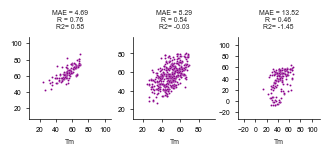

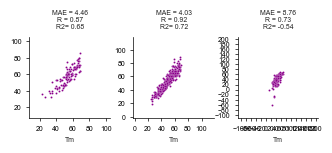

In [47]:
def plot_val_result_scatter(run_name, p='Tm', 
                            kalvin_Tm=False, center_Tm=True):
    val_result_df = pd.read_csv(os.path.join('./models/', run_name+'_val_result_df.csv'), index_col=1).rename(columns={'Unnamed: 0':'DatasetName'})

    val_result_df = val_result_df.join(mydata.annotation[['Series']])
    
    df_q = val_result_df.query('DatasetName == "arr"').query('Series == "MisMatches" | Series == "WatsonCrick"')

    # df_q = df_q.query(f'{p}_pred < 100 and {p}_pred > 0')
    
    df_q['n_mm'] = df_q.TargetStruct.apply(lambda x: int((x.count('.') - 4) / 2))

    # print(np.unique(df_q.n_mm, return_counts=True))
    # arr mismatch by #mm
    fig, ax = plt.subplots(1, 3, figsize=(8*cm,3*cm), sharey=False, sharex=False)
    for i in range(3):
        matplotlib.rc('axes',edgecolor='k', linewidth=.5)
        sns.scatterplot(
            data=df_q.query(f'n_mm == {i}'),
            x=p,
            y=f'{p}_pred',
            color='darkmagenta',
            linewidth=0.1,
            s=2,
            rasterized=False,
            ax=ax[i]
        )
        ax[i].axis('square')
        if p == 'Tm':
            tick_spacing = 20
        else:
            tick_spacing = 2
            
        util.beutify(ax[i], x_locator=tick_spacing, y_locator=tick_spacing, 
                     force_same_xy=True, add_margin=.2, shrink=True, do_not_resize=True)
        # ax[i].set_title(s)
        # print(i,len(df_q.query(f'n_mm == "{i}"')))
        metric = modeling.get_metric_dict(df_q.query(f'n_mm == {i}'), p)
        # ax[i].set_title('%s\nMAE = %.2f\ncorr = %.2f' % (s, metric['adjusted_mae'], metric['corr']))
        ax[i].set_title('MAE = %.2f\nR = %.2f\nR2= %.2f' % (metric['adjusted_mae'], metric['corr'], metric['r2']), size=5)
        ax[i].set_ylabel(None)

    fig.tight_layout(pad=.1, w_pad=0)
    # util.save_fig('./fig/Fig4/scatterplot/%s/array_test.pdf' % run_name)
    
    
for run_name in run_names:
    print(run_name)
    plot_val_result_scatter(run_name, 'Tm')

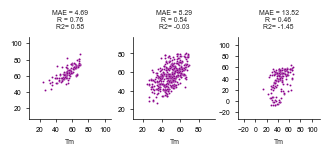

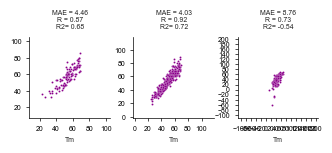

In [48]:
# run_names = ['dna04', # original nupack model
#     'swift-lake-118', # 178 NUPACK-compatible model
#     'hyb-adj-val', # updated NUPACK-compatible model
#     'vivid-spaceship-120',] # 1338 richer parameterization model
# run_names = [
#     # 'swift-lake-118', # 178 NUPACK-compatible model
#     'hyb-adj-ext-test',]
ov_nmm_r2_arr = np.zeros((len(run_names),4))
for i,run_name in enumerate(run_names):
    ov_nmm_r2_arr[i,:] = plot_val_result_scatter(run_name, p='Tm', kalvin_Tm=True)
    # util.save_multi_image('./fig/Fig4/Validation/%s_val_result.pdf'%run_name)